In [16]:

import numpy as np
import matplotlib.pyplot as plt
from heapq import heappop, heappush


# ===============================
# Configurable Parameters
# ===============================

GRID_RESOLUTION = 0.02  # meters per cell
OBSTACLE_RADIUS = 0.06  # 12 cm / 2
SAFETY_MARGIN = 0.15  # 15 cm buffer for quadrotor
GATE_WIDTH = 0.40  # 40 cm gate width

# ===============================
# Environment Definition
# ===============================

START = [-1.0, -3.0]
END = [-0.5, 2.0]

NOMINAL_GATES = [
    [0.5, -2.5, 0, 0, 0, -1.57, 0],
    [2.0, -1.5, 0, 0, 0, 0, 0],
    [0.0, 0.5, 0, 0, 0, 1.57, 0],
    [-0.5, 1.5, 0, 0, 0, 0, 0]
]

NOMINAL_OBSTACLES = [
    [1.5, -2.5, 0],
    [0.5, -1.0, 0],
    [1.5, 0, 0],
    [-1.0, 0, 0]
]

gates = np.array(NOMINAL_GATES)
obstacles = np.array(NOMINAL_OBSTACLES)

# ===============================
# Grid Utilities
# ===============================

def yaw_to_dir(yaw):
    return np.array([np.sin(yaw), np.cos(yaw)])


def get_gate_path(gate, approach_dist=0.3):
    """Compute entry and exit points for a gate."""
    pos = gate[:2]
    yaw = gate[5]
    direction = yaw_to_dir(yaw)
    entry = pos - direction * approach_dist
    exit_ = pos + direction * approach_dist
    return entry, exit_

def world_to_grid(pos, bounds, resolution):
    """Converts world coordinates to grid indices."""
    x0, y0, x1, y1 = bounds
    return int((pos[0] - x0) / resolution), int((pos[1] - y0) / resolution)

def grid_to_world(ix, iy, bounds, resolution):
    x0, y0, _, _ = bounds
    return np.array([x0 + ix * resolution, y0 + iy * resolution])

def make_obstacle_grid(bounds, resolution, obstacles, radius):
    """Returns a 2D grid map with obstacles expanded by safety margin."""
    nx = int((bounds[2] - bounds[0]) / resolution)
    ny = int((bounds[3] - bounds[1]) / resolution)
    grid = np.zeros((nx, ny), dtype=bool)

    for obs in obstacles:
        ox, oy = obs[:2]
        for ix in range(nx):
            for iy in range(ny):
                x, y = grid_to_world(ix, iy, bounds, resolution)
                if np.linalg.norm([x - ox, y - oy]) <= radius + SAFETY_MARGIN:
                    grid[ix, iy] = True
    return grid


In [17]:

# ===============================
# Plot Utilities
# ===============================

def plot_map_and_path(bounds, path):
    fig, ax = plt.subplots(figsize=(10, 8))

    # Plot gates
    for gate in gates:
        pos = gate[:2]
        yaw = gate[5]
        dir_vec = yaw_to_dir(yaw)
        perp_vec = np.array([-dir_vec[1], dir_vec[0]])
        p1 = pos - perp_vec * (GATE_WIDTH / 2)
        p2 = pos + perp_vec * (GATE_WIDTH / 2)
        ax.plot([p1[0], p2[0]], [p1[1], p2[1]], 'b-', lw=4)
        ax.text(*pos, 'Gate', fontsize=8, color='blue')

    # Plot obstacles
    for obs in obstacles:
        circle = plt.Circle(obs[:2], OBSTACLE_RADIUS + SAFETY_MARGIN, color='red', alpha=0.5)
        ax.add_patch(circle)

    # Plot path
    if path is not None:
        ax.plot(path[:,0], path[:,1], 'k-', lw=2, label='A* Path')
        ax.scatter(path[:,0], path[:,1], c='black', s=10)

    ax.plot(*START, 'go', markersize=10, label='Start')
    ax.plot(*END, 'mo', markersize=10, label='End')

    ax.set_xlim(bounds[0], bounds[2])
    ax.set_ylim(bounds[1], bounds[3])
    ax.set_aspect('equal')
    ax.grid(True)
    ax.axis('equal')
    ax.legend()
    ax.set_title("Yaw-Aware Gate Path Planning with A*")
    plt.show()

In [18]:

# ===============================
# A* Pathfinding
# ===============================

def heuristic(a, b):
    return np.linalg.norm(np.array(a) - np.array(b))

def a_star(start, goal, grid, bounds, resolution):
    """Simple A* path planner on a 2D grid."""
    start_ix, start_iy = world_to_grid(start, bounds, resolution)
    goal_ix, goal_iy = world_to_grid(goal, bounds, resolution)

    nx, ny = grid.shape
    visited = set()
    parent = {}
    cost = { (start_ix, start_iy): 0 }
    queue = [(0, (start_ix, start_iy))]

    while queue:
        _, current = heappop(queue)
        if current == (goal_ix, goal_iy):
            break
        if current in visited:
            continue
        visited.add(current)

        for dx, dy in [(-1,0), (1,0), (0,-1), (0,1), (-1,-1), (1,1), (-1,1), (1,-1)]:
            nx_ = current[0] + dx
            ny_ = current[1] + dy
            if 0 <= nx_ < nx and 0 <= ny_ < ny and not grid[nx_, ny_]:
                next_node = (nx_, ny_)
                new_cost = cost[current] + np.linalg.norm([dx, dy]) * resolution
                if next_node not in cost or new_cost < cost[next_node]:
                    cost[next_node] = new_cost
                    priority = new_cost + np.linalg.norm(np.array([nx_, ny_]) - np.array([goal_ix, goal_iy]))
                    heappush(queue, (priority, next_node))
                    parent[next_node] = current

    # Reconstruct path
    path = []
    node = (goal_ix, goal_iy)
    while node != (start_ix, start_iy):
        path.append(grid_to_world(*node, bounds, resolution))
        node = parent.get(node)
        if node is None:
            return []  # no path
    path.append(start)
    path.reverse()
    return np.array(path)


In [19]:
# ===============================
# Main Planning Routine
# ===============================

def compute_full_path():
    # Determine bounds from all data
    all_points = np.vstack([gates[:, :2], obstacles[:, :2], START, END])
    margin = 1.0
    min_xy = np.min(all_points, axis=0) - margin
    max_xy = np.max(all_points, axis=0) + margin
    bounds = [min_xy[0], min_xy[1], max_xy[0], max_xy[1]]

    # Obstacle map
    grid = make_obstacle_grid(bounds, GRID_RESOLUTION, obstacles, OBSTACLE_RADIUS)

    # Create full waypoint list: START → entry_i → gate_i → ... → END
    waypoints = [START]
    for gate in gates:
        entry, exit_ = get_gate_path(gate)
        waypoints.append(entry)
        waypoints.append(exit_)
    waypoints.append(END)

    # Plan between each segment
    full_path = []
    for i in range(len(waypoints) - 1):
        seg = a_star(waypoints[i], waypoints[i+1], grid, bounds, GRID_RESOLUTION)
        if len(seg) > 0:
            if i > 0:
                seg = seg[1:]  # remove duplicate point
            full_path.append(seg)
    return bounds, np.vstack(full_path)

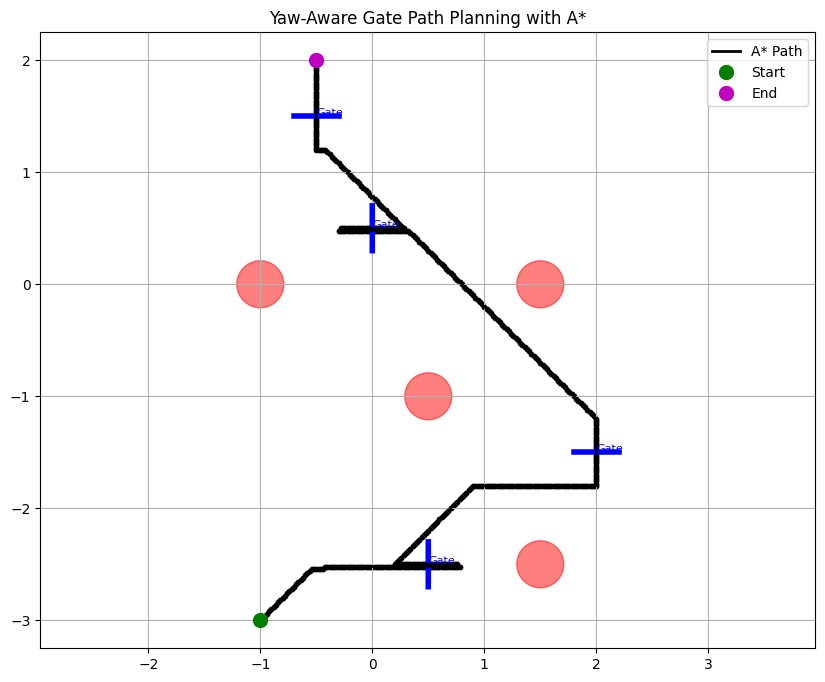

In [20]:
# Run the pipeline
bounds, full_path = compute_full_path()
plot_map_and_path(bounds, full_path)
